无通信的多智能体就是多组单智能体而已.分别实现即可.

每一组智能体有各自的actor,critic,并且不通信任何的数据.

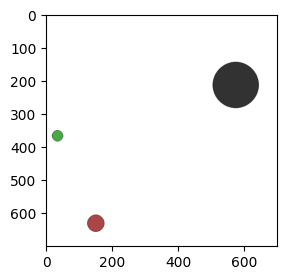

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        from pettingzoo.mpe import simple_tag_v3
        env = simple_tag_v3.env(num_good=1,
                                num_adversaries=1,
                                num_obstacles=1,
                                max_cycles=1e8,
                                render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        self.env.reset()
        self.step_n = 0
        return self.state()

    def state(self):
        state = []
        for i in self.env.agents:
            state.append(env.observe(i).tolist())
        state[-1].extend([0.0, 0.0])
        return state

    def step(self, action):
        reward_sum = [0, 0]
        for i in range(5):
            if i != 0:
                action = [-1, -1]
            next_state, reward, over = self._step(action)
            for j in range(2):
                reward_sum[j] += reward[j]
            self.step_n -= 1

        self.step_n += 1

        return next_state, reward_sum, over

    def _step(self, action):
        for i, _ in enumerate(env.agent_iter(2)):
            self.env.step(action[i] + 1)

        reward = [self.env.rewards[i] for i in self.env.agents]

        _, _, termination, truncation, _ = env.last()
        over = termination or truncation

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 100:
            over = True

        return self.state(), reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()
env.reset()

env.show()

In [2]:
import torch


class A2C:

    def __init__(self, model_actor, model_critic, model_critic_delay,
                 optimizer_actor, optimizer_critic):
        self.model_actor = model_actor
        self.model_critic = model_critic
        self.model_critic_delay = model_critic_delay
        self.optimizer_actor = optimizer_actor
        self.optimizer_critic = optimizer_critic

        self.model_critic_delay.load_state_dict(self.model_critic.state_dict())
        self.requires_grad(self.model_critic_delay, False)

    def soft_update(self, _from, _to):
        for _from, _to in zip(_from.parameters(), _to.parameters()):
            value = _to.data * 0.99 + _from.data * 0.01
            _to.data.copy_(value)

    def requires_grad(self, model, value):
        for param in model.parameters():
            param.requires_grad_(value)

    def train_critic(self, state, reward, next_state, over):
        self.requires_grad(self.model_critic, True)
        self.requires_grad(self.model_actor, False)

        #计算values和targets
        value = self.model_critic(state)

        with torch.no_grad():
            target = self.model_critic_delay(next_state)
        target = target * 0.99 * (1 - over) + reward

        #时序差分误差,也就是tdloss
        loss = torch.nn.functional.mse_loss(value, target)

        loss.backward()
        self.optimizer_critic.step()
        self.optimizer_critic.zero_grad()
        self.soft_update(self.model_critic, self.model_critic_delay)

        #减去value相当于去基线
        return (target - value).detach()

    def train_actor(self, state, action, value):
        self.requires_grad(self.model_critic, False)
        self.requires_grad(self.model_actor, True)

        #重新计算动作的概率
        prob = self.model_actor(state)
        prob = prob.gather(dim=1, index=action)

        #根据策略梯度算法的导函数实现
        #函数中的Q(state,action),这里使用critic模型估算
        prob = (prob + 1e-8).log() * value
        loss = -prob.mean()

        loss.backward()
        self.optimizer_actor.step()
        self.optimizer_actor.zero_grad()

        return loss.item()


model_actor = [
    torch.nn.Sequential(
        torch.nn.Linear(10, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 4),
        torch.nn.Softmax(dim=1),
    ) for _ in range(2)
]

model_critic = [
    torch.nn.Sequential(
        torch.nn.Linear(10, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 1),
    ) for _ in range(2)
]

model_critic_delay = [
    torch.nn.Sequential(
        torch.nn.Linear(10, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 1),
    ) for _ in range(2)
]

optimizer_actor = [
    torch.optim.Adam(model_actor[i].parameters(), lr=1e-3) for i in range(2)
]

optimizer_critic = [
    torch.optim.Adam(model_critic[i].parameters(), lr=5e-3) for i in range(2)
]

a2c = [
    A2C(model_actor[i], model_critic[i], model_critic_delay[i],
        optimizer_actor[i], optimizer_critic[i]) for i in range(2)
]

model_actor = None
model_critic = None
model_critic_delay = None
optimizer_actor = None
optimizer_critic = None

a2c

[<__main__.A2C at 0x7f979661eca0>, <__main__.A2C at 0x7f97965b5880>]

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []

    s = env.reset()
    o = False
    while not o:
        a = []
        for i in range(2):
            #计算动作
            prob = a2c[i].model_actor(torch.FloatTensor(s[i]).reshape(
                1, -1))[0].tolist()
            a.append(random.choices(range(4), weights=prob, k=1)[0])

        #执行动作
        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state)
    action = torch.LongTensor(action).unsqueeze(-1)
    reward = torch.FloatTensor(reward).unsqueeze(-1)
    next_state = torch.FloatTensor(next_state)
    over = torch.LongTensor(over).reshape(-1, 1)

    return state, action, reward, next_state, over, reward.sum(
        dim=0).flatten().tolist()


state, action, reward, next_state, over, reward_sum = play()

reward_sum

[30.0, -681.0654296875]

In [4]:
def train():
    #训练N局
    for epoch in range(5_0000):
        state, action, reward, next_state, over, _ = play()

        for i in range(2):
            value = a2c[i].train_critic(state[:, i], reward[:, i],
                                        next_state[:, i], over)
            loss = a2c[i].train_actor(state[:, i], action[:, i], value)

        if epoch % 2500 == 0:
            test_result = [play()[-1] for _ in range(20)]
            test_result = torch.FloatTensor(test_result).mean(dim=0).tolist()
            print(epoch, loss, test_result)


train()

0 -2.52531099319458 [6.0, -1572.4345703125]
2500 -2.2057106494903564 [133.5, -160.2089385986328]
5000 -0.4346385896205902 [68.5, -88.4798355102539]
7500 -0.7878077626228333 [36.0, -57.25299072265625]
10000 -0.4243254065513611 [20.0, -28.127361297607422]
12500 -0.10560104995965958 [19.5, -21.97000503540039]
15000 -0.20183932781219482 [15.5, -17.28420639038086]
17500 -0.09082813560962677 [8.0, -17.061660766601562]
20000 0.04816720634698868 [12.5, -17.330961227416992]
22500 -0.03879740089178085 [8.0, -12.067501068115234]
25000 -0.19893258810043335 [19.0, -19.506542205810547]
27500 -0.038775209337472916 [14.0, -17.891183853149414]
30000 0.018680671229958534 [16.5, -18.37790298461914]
32500 -0.044296279549598694 [1.5, -9.976574897766113]
35000 -0.007319218944758177 [11.5, -14.802574157714844]
37500 0.001401672256179154 [5.0, -9.788602828979492]
40000 -0.32673946022987366 [12.5, -14.883753776550293]
42500 -0.012928042560815811 [8.5, -8.822985649108887]
45000 0.08175945281982422 [10.5, -13.74

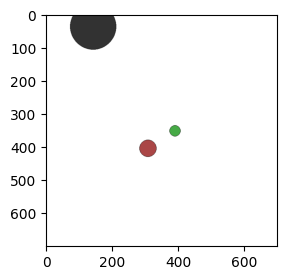

[0.0, 0.0]

In [5]:
play(True)[-1]